Final Portfolio Value: 475036.28402918216


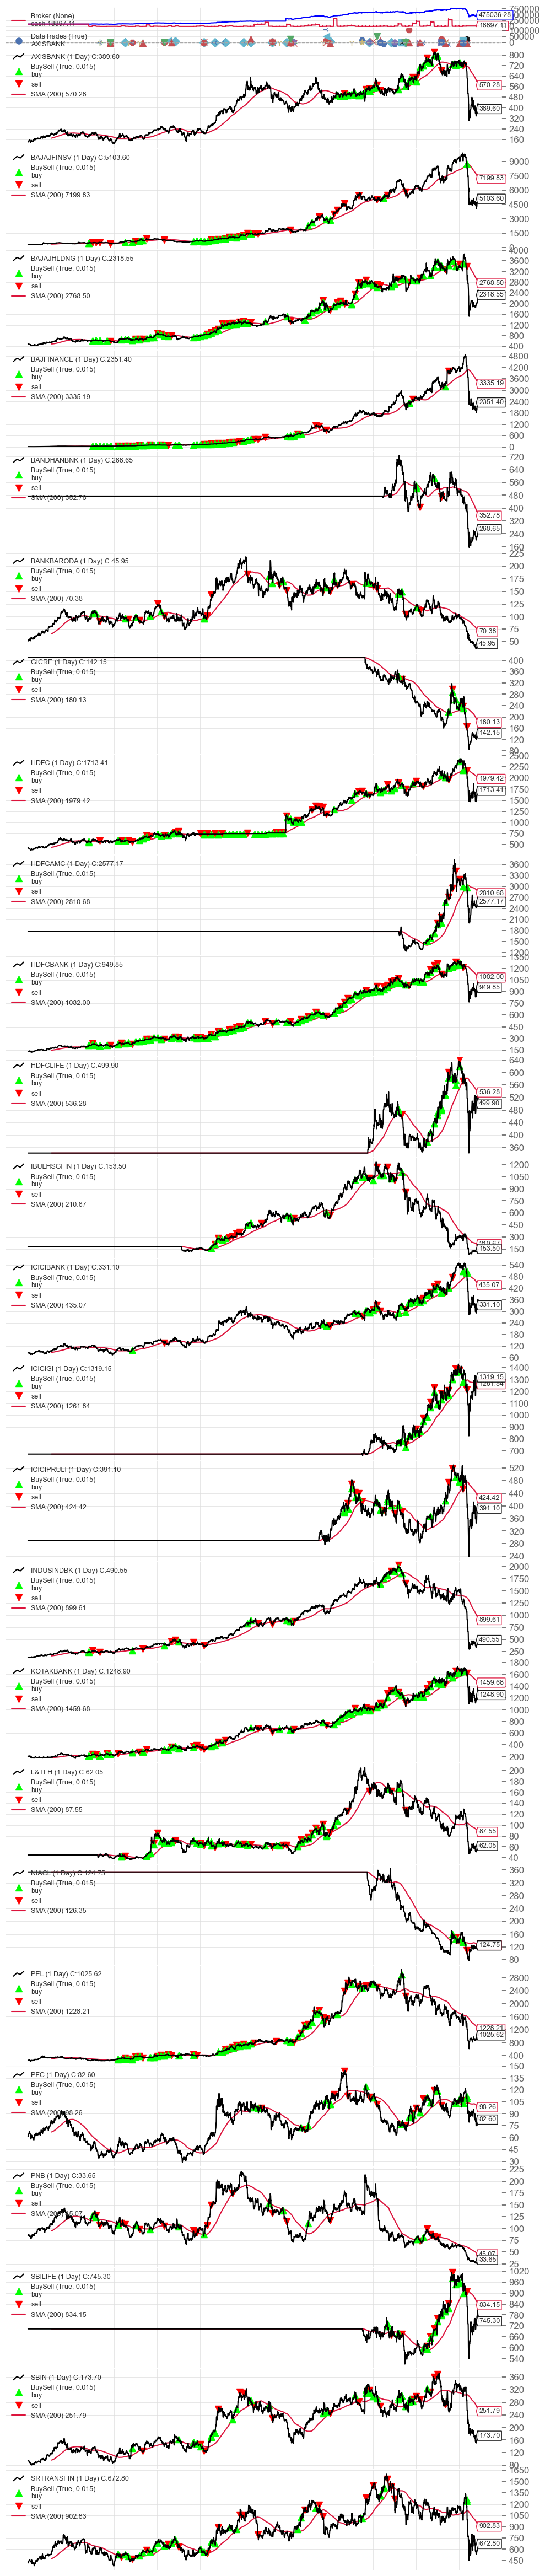

<IPython.core.display.Javascript object>

                           Strategy
-------------------------  ----------
Start Period               2010-01-04
End Period                 2020-06-15
Risk-Free Rate             0.0%
Time in Market             61.0%

Cumulative Return          375.04%
CAGR﹪                     16.08%

Sharpe                     0.62
Prob. Sharpe Ratio         99.87%
Smart Sharpe               0.62
Sortino                    1.13
Smart Sortino              1.13
Sortino/√2                 0.8
Smart Sortino/√2           0.8
Omega                      1.23

Max Drawdown               -47.55%
Longest DD Days            475
Volatility (ann.)          19.2%
Calmar                     0.34
Skew                       15.66
Kurtosis                   673.92

Expected Daily %           0.04%
Expected Monthly %         1.24%
Expected Yearly %          15.22%
Kelly Criterion            9.5%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.94%
Expected Shortfall (cVaR)  -1.94%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-17,2020-03-24,2020-06-15,150,-47.545848,-46.398246
2,2013-01-05,2013-08-28,2014-04-25,475,-23.705897,-18.992230
3,2011-07-26,2011-12-31,2012-02-03,192,-20.523147,-19.405670
4,2016-10-06,2016-12-24,2017-02-04,121,-17.047508,-16.131741
5,2018-07-28,2018-10-09,2019-03-20,235,-15.043858,-13.570933


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

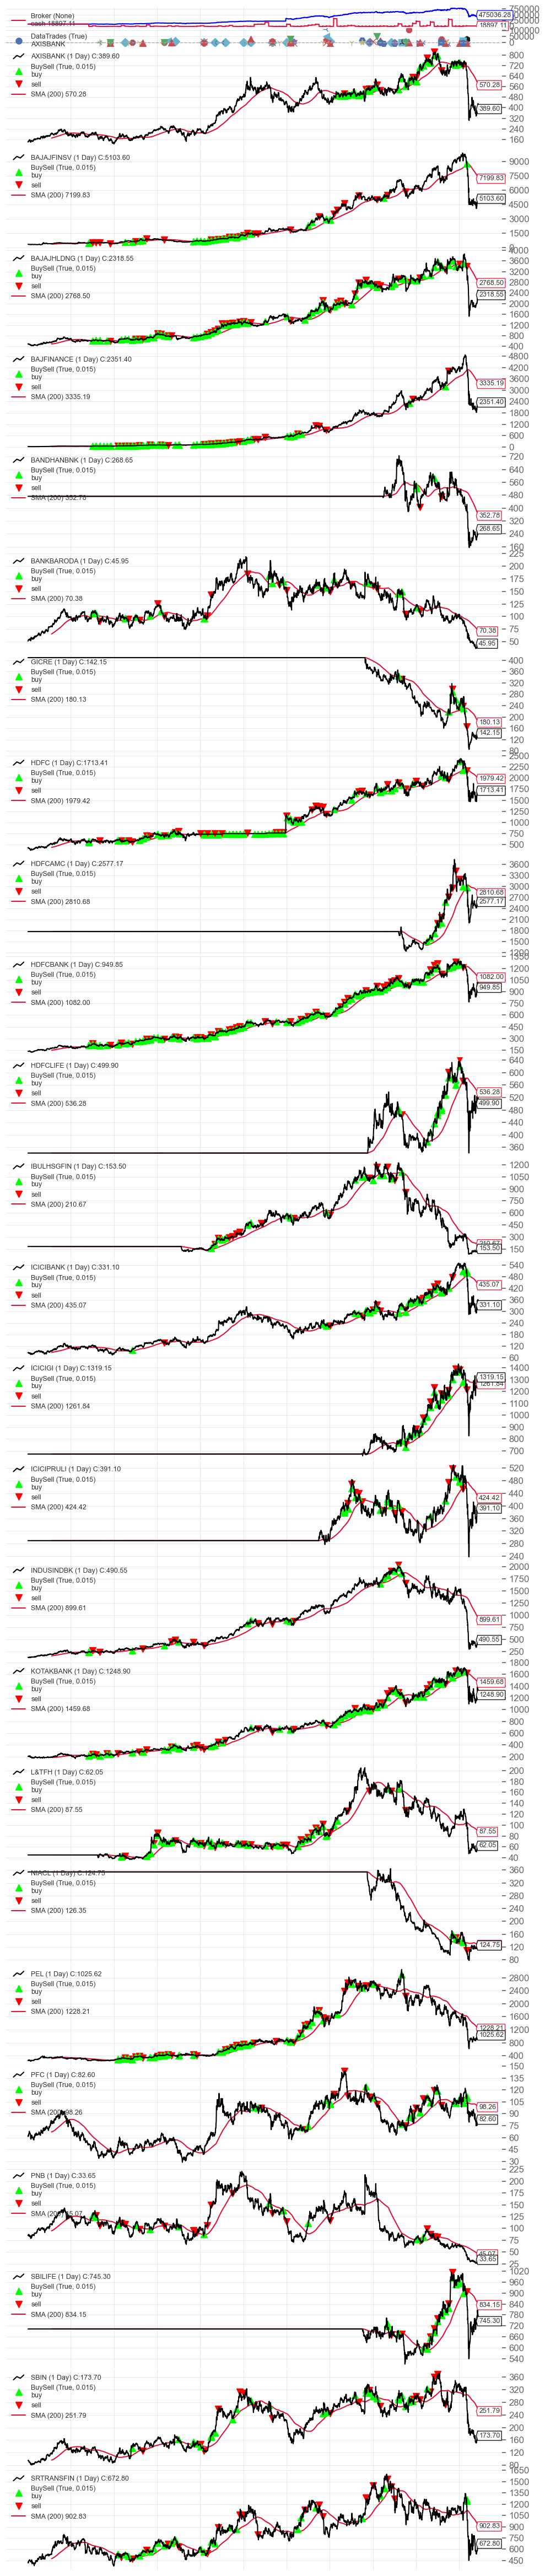

In [12]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
import matplotlib
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
from datetime import datetime
import quantstats as qstats
%matplotlib inline

# Read the CSV file using pandas
df = pd.read_csv('prices.csv')

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

stock_start_date = df['date'].min() # Earliest Start Date in all Stock Data Start Dates
stock_end_date = df['date'].max() # Latest End Date in all Stock Data Start Dates

starting_dict = {} # To hold Start Dates for all 25 stocks

# Creating a DataFrame with all combinations of tickers and dates
tickers = df['ticker'].unique()
dates = pd.date_range(start=stock_start_date, end=stock_end_date, freq='D')
index = pd.MultiIndex.from_product([tickers, dates], names=['ticker', 'date'])
dummy_df = pd.DataFrame(index=index).reset_index()

# Populating the starting_dict dictionary with the starting date of each stock
for ticker in tickers:
    starting_dict[ticker] = df[df['ticker'] == ticker]['date'].min()

# Adding 200 days to the starting date of each stock
for ticker in tickers:
    starting_dict[ticker] = starting_dict[ticker] + pd.Timedelta(days=200)

# Merging the dummy DataFrame with the original DataFrame on the 'ticker' and 'date' columns
merged_df = pd.merge(dummy_df, df, on=['ticker', 'date'], how='left')

# Backward filling missing values in the 'close' column with the next available value within each group of 'ticker'
merged_df[['close','open','high','low']] = merged_df.groupby('ticker')[['close','open','high','low']].fillna(method='bfill')

# Updating the original DataFrame with the merged DataFrame
df = merged_df

# Converting the 'date' column to a datetime object with the specified format again (this line is redundant)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Setting the 'date' column as the index of the DataFrame
df = df.set_index('date')

df

class MyStrategy(bt.Strategy):

    params = (
        ('sma_period', 200),  # SMA period
        ('lookback_period', 500),  # Lookback Period to calculate returns
        ('rebalance_day', 1),  # Rebalancing at the Start of Each Month
        ('max_weight',0.95),  # maximum portfolio value to be invested on a single day
        ('days',5) # number of days you want to carry forward buying alpha % of stocks
    )

    def __init__(self):
        self.first_trading_day = False
        self.current_month = None
        self.prev_month = None
        self.has_position = False
        self.start_date = starting_dict
        self.sma_200 = [bt.ind.SMA(data, period=self.params.sma_period) for data in self.datas]
        self.selected_stocks = []
        self.selected_data = []
        self.rebalance_dates = set()  # Store rebalance dates
        self.weights = np.zeros(len(self.datas))


    def filter_stocks(self):
        self.selected_data = []
        for i, d in enumerate(self.datas):
            if pd.Timestamp(d.datetime.date(0)) > self.start_date[d._name]:
                if self.datas[i].close[0] > self.sma_200[i][0]:
                    self.selected_data.append(d._name)

                elif self.datas[i].close[0] < self.sma_200[i][0]:
                    pass

        self.selected_stocks = [d for d in self.datas if d._name in self.selected_data]        


        if len(self.selected_stocks)>0:
            self.get_returns(self.selected_stocks)
            
        for stock in self.selected_stocks:
            first_day_of_month = stock.datetime.date().replace(day=1)
            self.rebalance_dates.add(first_day_of_month)

    def mean_variance_optimization(self,returns):
        n = returns.shape[1]
        Sigma = np.cov(returns.T)
        if Sigma.shape == ():
            Sigma = np.array([[Sigma]])
        P = matrix(Sigma)
        q = matrix(np.zeros((n, 1)))
        G = matrix(-np.eye(n))
        h = matrix(np.zeros((n, 1)))
        A = matrix(np.ones((1, n)))
        b = matrix(np.array([1.]))
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h, A, b)
        return np.array(sol['x']).flatten()
    

    def get_returns(self, selected_stocks):

        if len(self.datas[0]) < self.params.lookback_period:
            self.weights=np.zeros(len(self.selected_data))
            return
        
        # Initializing variables to store prices and returns for each data feed
        n_portfolios = len(self.selected_data)
        if n_portfolios == 0:
            return
        
        if n_portfolios == 1:
            self.weights = [1]
            return
        
        prices = np.zeros((self.params.lookback_period,len(selected_stocks)))
        returns = np.zeros((self.params.lookback_period,len(selected_stocks)))

        for i, d in enumerate(selected_stocks):
            prices[:, i] = d.close.get(size=self.params.lookback_period)
            returns[1:, i] = np.diff(prices[:, i]) / prices[:-1, i]

        self.weights = self.mean_variance_optimization(returns)

        self.place_order(selected_stocks)


    def place_order(self, selected_stocks):
        weights = np.array(self.weights) * self.params.max_weight

        # Selling the stocks not selected
        for i, d in enumerate(self.datas):
            if d not in selected_stocks:
                #self.order_target_percent(data=d, target=0.0)
                self.close(data=d)
        for i, d in enumerate(selected_stocks):
            self.order_target_percent(data=d, target=weights[i])
        self.weights -= weights

    def residual_buy(self):
        weights = np.array(self.weights)*self.params.max_weight
        for i,d in enumerate(self.selected_stocks):
            current_value = self.broker.get_value([d])
            additional_value = weights[i] * self.broker.get_value()
            target_value = current_value + additional_value
            self.order_target_value(data=d, target=target_value)
        self.weights -= weights
          
    def next(self):
        self.current_month = self.data.datetime.date().month
        if self.prev_month is None or self.current_month != self.prev_month:
            self.first_trading_day = True
        else:
            self.first_trading_day = False
        if self.first_trading_day:
            self.timer =  self.params.days
            self.filter_stocks()
        
        if self.timer>0 and self.first_trading_day == False:
            self.residual_buy()
            self.timer-=1
        self.prev_month = self.current_month


# Create an empty cerebro instance
cerebro = bt.Cerebro()

# Add your strategy to cerebro
cerebro.addstrategy(MyStrategy)

# Looping over each unique value in the 'ticker' column of the DataFrame
for ticker in df['ticker'].unique():
    # Creating a new DataFrame with only rows where the 'ticker' column is equal to the current ticker
    stock_df = df[df['ticker'] == ticker]
    
    # Creating a data feed from the new DataFrame using the 'bt.feeds.PandasData' class
    datafeed = bt.feeds.PandasData(dataname=stock_df,
                                  open='close',
                                  close='close',
                                  high='close',
                                  low='close',
                                  volume=None,
                                  openinterest=None,
                                  datetime=None,
                                  fromdate=datetime(2010, 1, 4),
                                  todate=datetime(2020, 6, 15))
    
    # Adding the data feed to the Cerebro instance with a name equal to the current ticker
    cerebro.adddata(datafeed, name=ticker)

# Set the cash for cerebro
cerebro.broker.setcash(100000.00)

cerebro.broker.setcommission(commission=0.001)

# Adding the PyFolio analyzer to the Cerebro instance
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run cerebro
strategy_run = cerebro.run()

print('Final Portfolio Value:', cerebro.broker.getvalue())

cerebro.plot(volume=False, iplot=False)

# Set the figure size for the plot
plt.rcParams['figure.figsize'] = [10,50]

# Update the font size for the plot
plt.rcParams.update({'font.size': 12})

# Analyze results and plot the backtest
cerebro.plot(volume=False)

# Get the final strategy object
strategy_final = strategy_run[-1]

# Get the pyfolio analyzer from the strategy
pyfolio_object = strategy_final.analyzers.getbyname('pyfolio')

# Retrieve various portfolio items from the pyfolio analyzer
stock_returns, positions, transactions, gross_lev = pyfolio_object.get_pf_items()

# Remove timezone information from the index of stock_returns
stock_returns.index = stock_returns.index.tz_convert(None)

# Generate full performance report using quantstats library
try:
    qstats.reports.full(stock_returns)
except TypeError:
    pass

plt.savefig('quant_stats_final.png')

import quantstats as qs

# Extract the PyFolio analyzer results from the strategy run
pyfolio_analyzer = strategy_run[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

# Convert the returns series to a DataFrame and reformat the index
returns_df = pd.DataFrame(returns)
returns_df.index = returns_df.index.tz_convert(None)

# Use QuantStats to generate a report and plot the results
qs.reports.html(returns_df['return'], output='report.html')
qs.plots.snapshot(returns_df['return'], title='Strategy Performance')

